# Transferring Image Styles

This notebook provides you with a complete code example that loads the content image, the style image, and the VGG16 pre-trained neural network, and uses them to transfer the style to the image.

## Loading the Content and Style Images

Load a crop of the content image ...

This image is sourced from the Drosophila ssTEM dataset, which is publicly available on Figshare: [Segmented anisotropic ssTEM dataset of neural tissue](https://figshare.com/articles/dataset/Segmented_anisotropic_ssTEM_dataset_of_neural_tissue/856713). This dataset provides a detailed view of neural tissue, aiding in the study of neural structures and patterns. The image can also be downloaded from the corresponding GitHub repository at [this link](http://github.com/unidesigner/groundtruth-drosophila-vnc), which offers additional resources and information related to the Drosophila ssTEM dataset.

In [7]:
from PIL import Image

content = Image.open("neuraltissue_with_colorlabels.png").convert("RGB") \
    .crop((100, 170, 100 + 256, 170 + 256))

... plot it ...

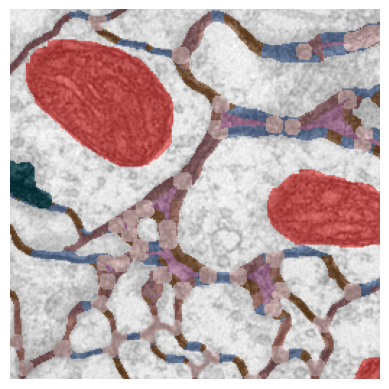

In [8]:
import matplotlib.pyplot as plt

plt.imshow(content)
plt.axis("off")
plt.show()

... load the style image ...

You'll use the style of the _trencadis_ lizard by Antoni Gaudi  in Parc Guell (Barcelona).

In [9]:
style = Image.open("lizard.png").convert("RGB").resize((256, 256))

... and plot it.

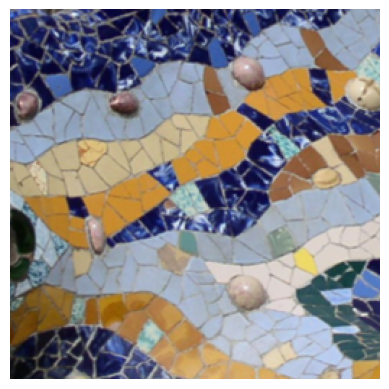

In [10]:
plt.imshow(style)
plt.axis("off")
plt.show()

## Loading a Pre-Trained Neural Network

In [11]:
from torchvision.models import vgg16, VGG16_Weights

model = vgg16(weights=VGG16_Weights.IMAGENET1K_V1)
model.eval()
model.requires_grad_(False)

print(model)

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

In [12]:
import numpy as np
import torch

mean = np.array([0.485, 0.456, 0.406], dtype=np.float32)
std = np.array([0.229, 0.224, 0.225], dtype=np.float32)

low = torch.tensor((- mean / std).reshape(1, -1, 1, 1))
high = torch.tensor(((1 - mean) / std).reshape(1, -1, 1, 1))

## Implementing Style Transfer

Implement a function to calculate the Gram matrix between all the activations of a specific layer ...

In [13]:
from torch import bmm

def gram(tensor):
    """Gram matrix."""
    batch_size, num_channels, height, width = tensor.size()
    features = tensor.view(batch_size, num_channels, height * width)
    gram_matrix = bmm(features, features.transpose(1, 2)) / (height * width)
    return gram_matrix

... define functions to to convert an image to a tensor, and vice versa ...

In [14]:
import torchvision.transforms as tt

def image_to_tensor(im, mean, std):
    """Convert image to tensor."""
    normalize = tt.Compose([tt.ToTensor(), tt.Normalize(mean, std)])
    return normalize(im).unsqueeze(0).requires_grad_(True)

def tensor_to_image(image, mean, std):
    """Convert tensor to image."""
    denormalize = tt.Normalize(mean=- mean / std, std=1 / std)
    im_array = denormalize(image.data.clone().detach().squeeze()).numpy()
    im_array = np.clip(im_array.transpose(1, 2, 0) * 255, 0, 255)
    im_array = im_array.astype(np.uint8)
    return Image.fromarray(im_array, "RGB")

... define a context manager class ...

In [15]:
class Fwd_Hooks():
    """Forward hooks."""

    def __init__(self, layers):
        """Initialize forward hooks."""
        self.hooks, self.activations_list = [], []
        for layer in layers:
            self.hooks.append(layer.register_forward_hook(self.hook_func))

    def hook_func(self, layer, input, output):
        """Save activations."""
        self.activations_list.append(output)

    def __enter__(self, *args): 
        """Enter context and register hooks."""
        return self
    
    def __exit__(self, *args): 
        """Exit context management and remove hooks."""
        for hook in self.hooks:
            hook.remove()

... and define a function to implement style transfer.

In [16]:
def style_transfer(image, content, style, content_layers, style_layers, 
                   lr=1, iter_num=100, beta=1e3):
    """Perform style transfer."""
    mean = np.array([0.485, 0.456, 0.406], dtype=np.float32)
    std = np.array([0.229, 0.224, 0.225], dtype=np.float32)

    image_tensor = image_to_tensor(image, mean, std)

    with Fwd_Hooks(content_layers) as fh:
        _ = model(image_to_tensor(content, mean, std))
    content_activations = [activations.detach() 
                           for activations in fh.activations_list]

    with Fwd_Hooks(style_layers) as fh:
        _ = model(image_to_tensor(style, mean, std))
    gram_targets = [gram(activations.detach()) 
                    for activations in fh.activations_list]

    optimizer = torch.optim.LBFGS([image_tensor], lr=lr)
    mse_loss = torch.nn.MSELoss(reduction="sum")

    def closure():
        """Closure function for the optimizer."""
        optimizer.zero_grad()

        with Fwd_Hooks(content_layers) as fh:
            _ = model(image_tensor)
        image_content_activations = fh.activations_list

        content_loss = 0
        for ia, ca in zip(image_content_activations, content_activations):
            n_f = ia.shape[1]
            content_loss = content_loss + mse_loss(ia, ca) / n_f ** 2
        content_loss = content_loss / len(image_content_activations)

        with Fwd_Hooks(style_layers) as fh:
            _ = model(image_tensor)
        gram_image = [gram(activations) for activations in fh.activations_list]

        style_loss = 0
        for gi, gt in zip(gram_image, gram_targets):
            n_g = gi.shape[1]
            style_loss = style_loss + mse_loss(gi, gt) / n_g ** 2
        style_loss = style_loss / len(gram_image)

        print(f"content_loss={content_loss} style_loss={style_loss}")

        total_loss = content_loss + beta * style_loss
        total_loss.backward()
        return total_loss

    for i in range(iter_num):
        print(f"iteration {i}")
        optimizer.step(closure)
        
        image = tensor_to_image(image_tensor, mean, std)
        
        if i <= 5 or i % 10 == 0 or i == iter_num - 1:
            plt.imshow(image)
            plt.title(f"Iteration {i}")
            plt.axis("off")
            plt.show()
    
    return image

## Transferring the Style of an Image to Another Image

iteration 0
content_loss=0.0 style_loss=1.904022216796875
content_loss=2.2325605186779285e-06 style_loss=1.903765082359314
content_loss=50.94096374511719 style_loss=1.256737232208252
content_loss=71.9765853881836 style_loss=0.8719501495361328
content_loss=98.09257507324219 style_loss=0.6601136922836304
content_loss=103.69862365722656 style_loss=0.5311434864997864
content_loss=116.78274536132812 style_loss=0.4235871434211731
content_loss=139.75015258789062 style_loss=0.3531608581542969
content_loss=134.07814025878906 style_loss=0.3257579207420349
content_loss=137.69540405273438 style_loss=0.292462021112442
content_loss=144.32125854492188 style_loss=0.2589743733406067
content_loss=149.62591552734375 style_loss=0.2305707186460495
content_loss=162.9700164794922 style_loss=0.2055056095123291
content_loss=162.5406036376953 style_loss=0.19190406799316406
content_loss=166.72146606445312 style_loss=0.17709560692310333
content_loss=169.4259490966797 style_loss=0.16421031951904297
content_loss=17

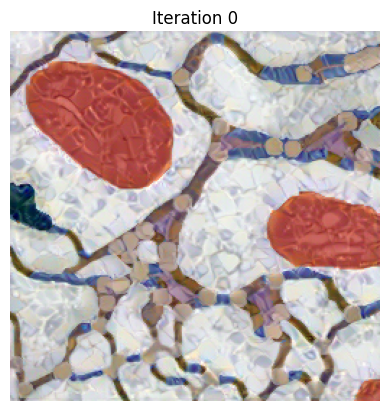

iteration 1
content_loss=193.63031005859375 style_loss=0.11301638185977936
content_loss=191.00653076171875 style_loss=0.12866702675819397
content_loss=197.62286376953125 style_loss=0.10344024002552032
content_loss=198.51634216308594 style_loss=0.10064537823200226
content_loss=200.45474243164062 style_loss=0.09756532311439514
content_loss=204.8618927001953 style_loss=0.09151075780391693
content_loss=205.24276733398438 style_loss=0.08828742802143097
content_loss=207.28346252441406 style_loss=0.08401796966791153
content_loss=211.6382598876953 style_loss=0.07904158532619476
content_loss=212.81704711914062 style_loss=0.07710902392864227
content_loss=216.1221923828125 style_loss=0.07449303567409515
content_loss=217.2612762451172 style_loss=0.07099217921495438
content_loss=221.0899658203125 style_loss=0.06646494567394257
content_loss=219.60047912597656 style_loss=0.06567443162202835
content_loss=222.5582275390625 style_loss=0.06450648605823517
content_loss=223.76828002929688 style_loss=0.0620

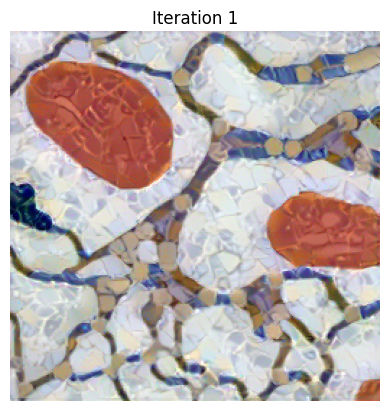

iteration 2
content_loss=229.268798828125 style_loss=0.05257400870323181
content_loss=231.0059814453125 style_loss=0.05100065469741821
content_loss=232.47451782226562 style_loss=0.04976627975702286
content_loss=232.73236083984375 style_loss=0.04867604374885559
content_loss=234.3578643798828 style_loss=0.047277070581912994
content_loss=234.57350158691406 style_loss=0.0459359847009182
content_loss=235.91465759277344 style_loss=0.043904419988393784
content_loss=238.34747314453125 style_loss=0.04229506477713585
content_loss=235.40130615234375 style_loss=0.046122293919324875
content_loss=238.43325805664062 style_loss=0.04140684753656387
content_loss=238.7708282470703 style_loss=0.04096461459994316
content_loss=236.71841430664062 style_loss=0.04543372243642807
content_loss=240.3189239501953 style_loss=0.0396902896463871
content_loss=240.54241943359375 style_loss=0.03910469263792038
content_loss=239.52835083007812 style_loss=0.04154474288225174
content_loss=241.44073486328125 style_loss=0.037

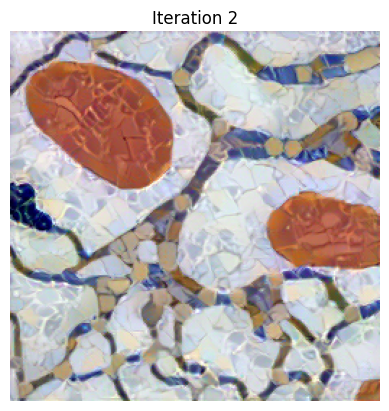

iteration 3
content_loss=241.0454559326172 style_loss=0.04105009883642197
content_loss=244.50970458984375 style_loss=0.033841874450445175
content_loss=244.94393920898438 style_loss=0.03327309712767601
content_loss=241.13038635253906 style_loss=0.040010787546634674
content_loss=245.79737854003906 style_loss=0.03215300291776657
content_loss=246.0642547607422 style_loss=0.0316375307738781
content_loss=243.42755126953125 style_loss=0.036840349435806274
content_loss=246.68223571777344 style_loss=0.030568543821573257
content_loss=246.97982788085938 style_loss=0.030095834285020828
content_loss=244.55062866210938 style_loss=0.03529955819249153
content_loss=247.79586791992188 style_loss=0.029112819582223892
content_loss=248.12757873535156 style_loss=0.02867279015481472
content_loss=246.0782928466797 style_loss=0.03291697055101395
content_loss=248.8957977294922 style_loss=0.02772499993443489
content_loss=249.24978637695312 style_loss=0.027299653738737106
content_loss=246.72610473632812 style_los

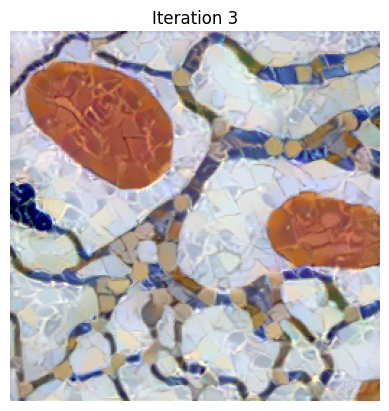

iteration 4
content_loss=251.58465576171875 style_loss=0.0248255655169487
content_loss=249.88229370117188 style_loss=0.02818748913705349
content_loss=252.31399536132812 style_loss=0.024054789915680885
content_loss=252.66390991210938 style_loss=0.023718319833278656
content_loss=250.8737030029297 style_loss=0.02742854878306389
content_loss=253.36317443847656 style_loss=0.023013025522232056
content_loss=253.68495178222656 style_loss=0.02268892712891102
content_loss=251.9142303466797 style_loss=0.02686208486557007
content_loss=254.37245178222656 style_loss=0.02203037217259407
content_loss=254.69752502441406 style_loss=0.02172379568219185
content_loss=253.0211181640625 style_loss=0.02503023110330105
content_loss=255.37191772460938 style_loss=0.021105248481035233
content_loss=255.6881561279297 style_loss=0.020824288949370384
content_loss=253.9930419921875 style_loss=0.02343716099858284
content_loss=256.2220153808594 style_loss=0.02025722526013851
content_loss=256.5384826660156 style_loss=0.0

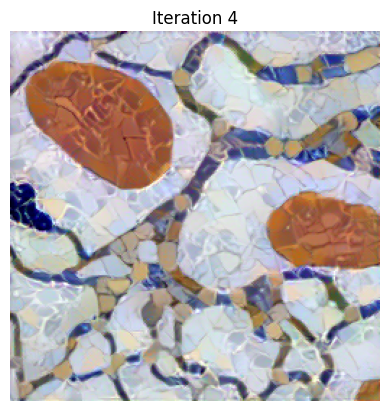

iteration 5
content_loss=257.90484619140625 style_loss=0.018712636083364487
content_loss=258.1176452636719 style_loss=0.018492672592401505
content_loss=256.178955078125 style_loss=0.021060669794678688
content_loss=258.5952453613281 style_loss=0.018006306141614914
content_loss=258.7372741699219 style_loss=0.01777968741953373
content_loss=256.3963623046875 style_loss=0.020797135308384895
content_loss=259.07305908203125 style_loss=0.0173482783138752
content_loss=259.1517333984375 style_loss=0.017140157520771027
content_loss=256.7033386230469 style_loss=0.019251083955168724
content_loss=259.34075927734375 style_loss=0.0167317483574152
content_loss=259.37701416015625 style_loss=0.016539379954338074
content_loss=257.8595886230469 style_loss=0.017650021240115166
content_loss=259.6293640136719 style_loss=0.016126533970236778
content_loss=259.6732482910156 style_loss=0.015956182032823563
content_loss=257.9653015136719 style_loss=0.017080767080187798
content_loss=259.9607238769531 style_loss=0.0

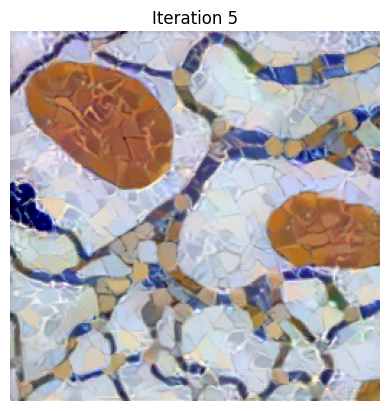

iteration 6
content_loss=257.68914794921875 style_loss=0.017094895243644714
content_loss=260.5669860839844 style_loss=0.01456115860491991
content_loss=260.56170654296875 style_loss=0.014417040161788464
content_loss=259.46820068359375 style_loss=0.015277190133929253
content_loss=260.5921936035156 style_loss=0.01408839225769043
content_loss=260.7387390136719 style_loss=0.0139481695368886
content_loss=258.1385192871094 style_loss=0.015470932237803936
content_loss=261.0301513671875 style_loss=0.013679763302206993
content_loss=261.071533203125 style_loss=0.013556405901908875
content_loss=259.6631774902344 style_loss=0.0144110769033432
content_loss=261.1411437988281 style_loss=0.013264814391732216
content_loss=261.2246398925781 style_loss=0.013142546638846397
content_loss=259.24981689453125 style_loss=0.01467569638043642
content_loss=261.4898376464844 style_loss=0.012894632294774055
content_loss=261.51513671875 style_loss=0.012779591605067253
content_loss=260.3177490234375 style_loss=0.01343

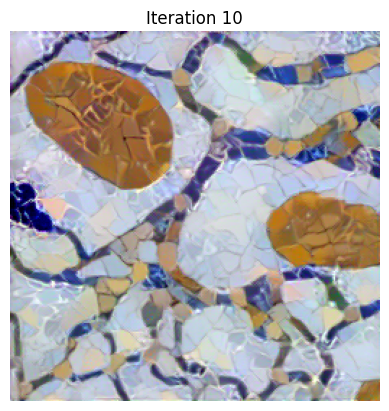

iteration 11
content_loss=260.9040832519531 style_loss=0.006980699487030506
content_loss=260.80023193359375 style_loss=0.006946512497961521
content_loss=259.645263671875 style_loss=0.007020747754722834
content_loss=260.5970458984375 style_loss=0.006869847886264324
content_loss=260.52752685546875 style_loss=0.006842632777988911
content_loss=259.2469787597656 style_loss=0.006993850227445364
content_loss=260.449951171875 style_loss=0.006766383536159992
content_loss=260.3666076660156 style_loss=0.00673773605376482
content_loss=259.32537841796875 style_loss=0.006802198477089405
content_loss=260.1794128417969 style_loss=0.006659404840320349
content_loss=260.1141662597656 style_loss=0.006631971802562475
content_loss=258.6562805175781 style_loss=0.0069826021790504456
content_loss=260.1164245605469 style_loss=0.006561620626598597
content_loss=260.05010986328125 style_loss=0.006532397121191025
content_loss=258.90423583984375 style_loss=0.0066615985706448555
content_loss=259.9501953125 style_loss

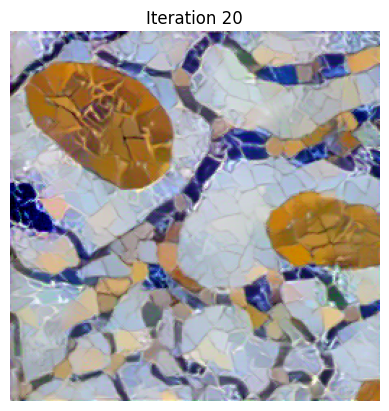

iteration 21
content_loss=247.72607421875 style_loss=0.0032140661496669054
content_loss=248.4650115966797 style_loss=0.003148924559354782
content_loss=248.3853302001953 style_loss=0.003141713095828891
content_loss=247.78738403320312 style_loss=0.0031579986680299044
content_loss=248.23219299316406 style_loss=0.003121007699519396
content_loss=248.1903076171875 style_loss=0.0031140861101448536
content_loss=247.6923065185547 style_loss=0.003121012356132269
content_loss=248.09390258789062 style_loss=0.0030916540417820215
content_loss=248.0691680908203 style_loss=0.0030853988137096167
content_loss=247.56166076660156 style_loss=0.0030984636396169662
content_loss=247.99832153320312 style_loss=0.003058637958019972
content_loss=247.96054077148438 style_loss=0.0030507713090628386
content_loss=247.3042755126953 style_loss=0.0030887830071151257
content_loss=247.87698364257812 style_loss=0.003032282693311572
content_loss=247.82176208496094 style_loss=0.003025972517207265
content_loss=247.392578125 s

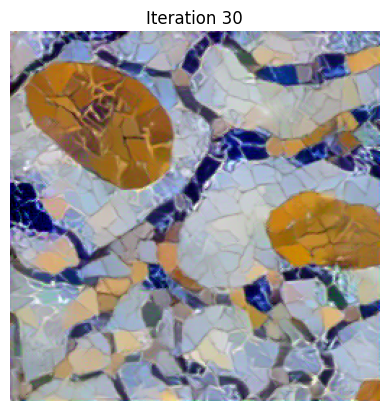

iteration 31
content_loss=235.08908081054688 style_loss=0.0017017762875184417
content_loss=234.96319580078125 style_loss=0.0016992862801998854
content_loss=234.91436767578125 style_loss=0.0016942681977525353
content_loss=234.85011291503906 style_loss=0.0016900546615943313
content_loss=234.78956604003906 style_loss=0.0016843978082761168
content_loss=234.61715698242188 style_loss=0.0016810245579108596
content_loss=234.68417358398438 style_loss=0.0016754765529185534
content_loss=234.5970001220703 style_loss=0.0016727391630411148
content_loss=234.55833435058594 style_loss=0.0016688576433807611
content_loss=234.45631408691406 style_loss=0.0016645699506625533
content_loss=234.43634033203125 style_loss=0.0016591824823990464
content_loss=234.23594665527344 style_loss=0.0016575852641835809
content_loss=234.2819061279297 style_loss=0.0016527412226423621
content_loss=234.25555419921875 style_loss=0.0016494005685672164
content_loss=234.2115020751953 style_loss=0.0016430349787697196
content_loss=23

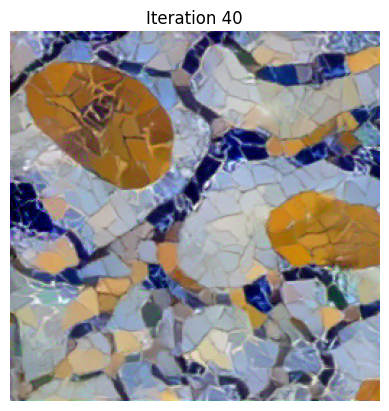

iteration 41
content_loss=224.6748504638672 style_loss=0.0011710047256201506
content_loss=224.61512756347656 style_loss=0.001168514252640307
content_loss=224.53829956054688 style_loss=0.0011668086517602205
content_loss=224.52447509765625 style_loss=0.001165212830528617
content_loss=224.4951171875 style_loss=0.0011629970977082849
content_loss=224.35906982421875 style_loss=0.001162987551651895
content_loss=224.3858184814453 style_loss=0.001160184619948268
content_loss=224.35574340820312 style_loss=0.001158854691311717
content_loss=224.2828369140625 style_loss=0.00115798634942621
content_loss=224.28851318359375 style_loss=0.0011562807485461235
content_loss=224.2120819091797 style_loss=0.0011550246272236109
content_loss=224.17982482910156 style_loss=0.001152783865109086
content_loss=224.12405395507812 style_loss=0.0011502293637022376
content_loss=224.02601623535156 style_loss=0.0011481508845463395
content_loss=223.98802185058594 style_loss=0.0011465048883110285
content_loss=224.0400390625 

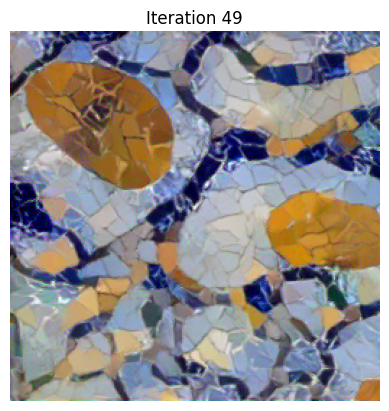

In [17]:
style_transfer(image=content, content=content, style=style,
    content_layers=[model.features[l] for l in [14]],
    style_layers=[model.features[l] for l in [0, 2, 5, 7, 10]],
    lr=1, iter_num=50, beta=1e5);